In [95]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt
/kaggle/input/bangla-translated-5k/val_translated - Sheet1.csv
/kaggle/input/bangla-translated-5k/translated-5k - Sheet1.csv


## Import Libraries

In [96]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertPreTrainedModel, BertModel

from transformers import AutoConfig, AutoTokenizer

In [97]:
# !pip install transformers
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import BertTokenizer, TFBertModel
!pip install git+https://github.com/csebuetnlp/normalizer
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
import torch

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-6h731nfx
     |████████████████████████████████| 184 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 2.1 MB/s  eta 0:00:01
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6885 sha256=521fbc9d89f1a671317b9ffe736c9e95fbe7e732801ad7d1ad277b951ebf4383
  Stored in directory: /tmp/pip-ephem-wheel-cache-i4tcgb1u/wheels/af/b1/ee/b9e2a2f2dd861976a357b6a6fa105aeedf2254016676f6cf8f
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186451 sha256=05ed65a000e83e6bf217adaef8e65f23c8ac1b8a9cac34b0f8071bed3f0e122a
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41913 sha256=eb4bfc4629b5ecd50bb72829115d8fcc79fb9607564a6f1e4e5427ba24fb163f
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f

In [98]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

## Load data

In [99]:
translated_df = pd.read_csv('/kaggle/input/bangla-translated-5k/translated-5k - Sheet1.csv',sep=',').sample(frac=1) #shuffling the data for train-val split
# test_df = pd.read_csv('../input/emotions-dataset-for-nlp/test.txt', sep=';')
# val_df = pd.read_csv('/kaggle/input/bangla-translated-5k/val (1).csv',sep=',').sample(frac=1)

In [100]:
translated_df.head(20)

,sentence,emotion
617,আমি ইদানীং একটু অলস বোধ করছি কিন্তু স্কুল এখনও...,sadness
193,আমি চাই যে লোকেরা আস্থা রাখুক যে তারা আমার চেয...,joy
3884,আমি হারিয়েছি এবং তারপরে নভেম্বরে খুঁজে পেয়েছ...,sadness
3374,সারা বছর ধরে আপনাদের কারো সাথে না থাকার কারণে ...,anger
1332,আরও কিছু করার জন্য আমাকে ক্রমাগত নিজের মধ্যে গ...,sadness
4912,আমি বিশ্বের দ্বারা অন্যায় বোধ করি,anger
1045,এমনকি একটি জীবন-হুমকিপূর্ণ রোগে আক্রান্ত হওয়া...,sadness
1857,আমি সবেমাত্র অত্যন্ত বিতাড়িত এবং নিরাপত্তাহীন...,fear
4669,আমার মনে হচ্ছে আমি এটাকে কুইল্ট করার গতি সহ্য ...,joy
2721,আমি পরের বছরটিকে একটি দুঃসাহসিক কাজ হিসাবে দেখ...,joy


In [101]:
from sklearn.model_selection import train_test_split

new_df = pd.DataFrame(translated_df)

train_df, val_df = train_test_split(
    new_df,
    test_size=0.20,
    random_state=24000,
    shuffle=True,
)

In [102]:
train_df.shape, val_df.shape

((3999, 2), (1000, 2))

In [103]:
train_df.columns = ['sentence', 'emotion']
val_df.columns = ['sentence', 'emotion']

In [104]:
dataset = pd.DataFrame(data=train_df, columns=['sentence', 'emotion'])
dataset.to_csv("train.csv")
print (dataset)

                                               sentence  emotion
2113  আমি অনুভব করি আমাদের পৃথিবী তখন অনেক বেশি নিষ্...      joy
3942  আমি ঘরে ঢুকে মোটামুটি শান্ত বোধ করলাম ফটোগ্রাফ...      joy
2511               আমি আমার মিষ্টি ছেলের জন্য অনুভব করি     love
619   আমি ঠিক সেই দিনের ইন্টারভিউ পোস্টের অংশে চলে য...      joy
4798  আমি এমনকি বলতে সাহস করি যে কিছু বড় স্টিলার এব...    anger
...                                                 ...      ...
1878  আমি এখন সেই ব্যথা অনুভব করছি এবং ভয় পাচ্ছি যে...     fear
2407  আমি মনে করি আমি সংগ্রাম করতে যাচ্ছি এবং ব্যর্থ...  sadness
4549  আমি আপনাকে অনেক দিন আগে পরীক্ষা করে দেখেছি আমি...      joy
4218  ক্লাসের প্রতিটি শিশুকে তারা মূল্যবান বলে মনে ক...      joy
2127  আমি কয়েক সপ্তাহ ধরে বিরক্তিকর ছিলাম এবং বৃষ্ট...  sadness

[3999 rows x 2 columns]


In [105]:
dataset = pd.DataFrame(data=val_df, columns=['sentence', 'emotion'])
dataset.to_csv("val.csv")
print (dataset)

                                               sentence   emotion
155   আমি সত্যিই ভুলে গিয়েছিলাম যে আন্তরিকভাবে হাসত...  surprise
1717  আমি বাইক চালিয়ে আমার আশেপাশে ফিরে আসি এবং আমা...       joy
371                      আমি ভেবেছিলাম আমি খালি বোধ করব   sadness
1037  আমি মূল্যহীন বোধ করি এবং আমি যে মূল্যবান সময় ...   sadness
2181          এই পরিবারকে জেনে আমি নিজেকে ধন্য মনে করছি      love
...                                                 ...       ...
4281  আমি তাকে সমর্থন বোধ করি আমি সাহায্য করতে পারি ...      love
4110  আমি কুৎসিত বোধ করি আমি একটি সুন্দর পোষাকের চেয...   sadness
4861  আমি একটি কিশোরী মেয়ের কথা শুনেছিলাম যে তার মু...   sadness
4606  আমি একটু কল্পনা করতে ঘৃণা করব যদি সেক্রেটারি স...     anger
2662  আমি বরং হৃদয়হীন বোধ করছি কারণ আমি সম্প্রতি নি...     anger

[1000 rows x 2 columns]


In [106]:
train_df.head()

,sentence,emotion
2113,আমি অনুভব করি আমাদের পৃথিবী তখন অনেক বেশি নিষ্...,joy
3942,আমি ঘরে ঢুকে মোটামুটি শান্ত বোধ করলাম ফটোগ্রাফ...,joy
2511,আমি আমার মিষ্টি ছেলের জন্য অনুভব করি,love
619,আমি ঠিক সেই দিনের ইন্টারভিউ পোস্টের অংশে চলে য...,joy
4798,আমি এমনকি বলতে সাহস করি যে কিছু বড় স্টিলার এব...,anger


In [107]:
val_df.head()

,sentence,emotion
155,আমি সত্যিই ভুলে গিয়েছিলাম যে আন্তরিকভাবে হাসত...,surprise
1717,আমি বাইক চালিয়ে আমার আশেপাশে ফিরে আসি এবং আমা...,joy
371,আমি ভেবেছিলাম আমি খালি বোধ করব,sadness
1037,আমি মূল্যহীন বোধ করি এবং আমি যে মূল্যবান সময় ...,sadness
2181,এই পরিবারকে জেনে আমি নিজেকে ধন্য মনে করছি,love


## EDA

In [108]:
train_df['emotion'].value_counts()

joy         1383
sadness     1114
anger        553
fear         439
love         358
surprise     152
Name: emotion, dtype: int64

In [109]:
val_df['emotion'].value_counts()

joy         365
sadness     269
anger       147
fear        107
love         74
surprise     38
Name: emotion, dtype: int64

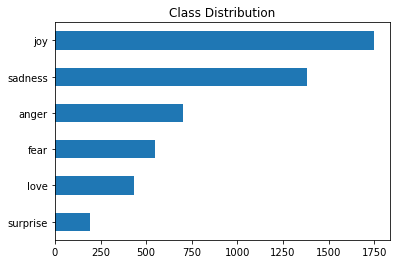

In [110]:
import matplotlib.pyplot as plt
# from matplotlib_inline import backend_inline
# backend_inline.set_matplotlib_formats('svg') # HD Plots

translated_df['emotion'].value_counts(ascending=True).plot.barh()
plt.title('Class Distribution')
plt.show()

In [111]:
# get max len of sentences
def max_len(data):
    return data['sentence'].apply(lambda x: len(x.split())).max()

max_lens = [max_len(train_df), max_len(val_df)]
max(max_lens)

67

In [112]:
# len(train_df['sentence'].iloc[4].split())

In [113]:
max_lens

[67, 60]

## Configs

In [114]:

MODEL_OUT_DIR = '/kaggle/working/models/bert_emotion'
TRAIN_FILE_PATH = '/kaggle/input/bangla-translated-5k/translated-5k - Sheet1.csv'
VALID_FILE_PATH = '/kaggle/input/bangla-translated-5k/val_translated - Sheet1.csv'
# TEST_FILE_PATH = '../input/emotions-dataset-for-nlp/test.txt'
## Model Configurations
MAX_LEN_TRAIN = 67
MAX_LEN_VALID = 55
# MAX_LEN_TEST = 68
BATCH_SIZE = 8
LR = 1e-5
NUM_EPOCHS = 10
# NUM_THREADS = 1  ## Number of threads for collecting dataset
MODEL_NAME = 'csebuetnlp/banglabert' #bert-large-uncased bert-base-uncased
LABEL_DICT = {'joy':0, 'sadness':1, 'anger':2, 'fear':3, 'love':4, 'surprise':5}

if not os.path.isdir(MODEL_OUT_DIR):
    os.makedirs(MODEL_OUT_DIR)

## Create Dataset

In [115]:
class Emotions_Dataset(Dataset):

    def __init__(self, filename, maxlen, tokenizer, label_dict): 
        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter = ',')
        # name columns
        self.df.columns = ['sentence', 'emotion']
        #Initialize the tokenizer for the desired transformer model
        self.df['emotion'] = self.df['emotion'].map(label_dict)
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):    
        #Select the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'sentence']
        label = self.df.loc[index, 'emotion']
        #Preprocess the text to be suitable for the transformer
        tokens = self.tokenizer.tokenize(sentence) 
        tokens = ['[CLS]'] + tokens + ['[SEP]'] 
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] 
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] 
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
        input_ids = torch.tensor(input_ids) 
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()
        
        label = torch.tensor(label, dtype=torch.long)
        
        return input_ids, attention_mask, label

In [116]:
class BertEmotionClassifier(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        #The classification layer that takes the [CLS] representation and outputs the logit
        self.cls_layer = nn.Linear(config.hidden_size, 6)

    def forward(self, input_ids, attention_mask):
        #Feed the input to Bert model to obtain contextualized representations
        reps, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        cls_reps = reps[:, 0]
        logits = self.cls_layer(cls_reps)
        return logits

In [117]:
train_df.shape

(3999, 2)

In [118]:
val_df.shape

(1000, 2)

In [119]:
val_df.head()

,sentence,emotion
155,আমি সত্যিই ভুলে গিয়েছিলাম যে আন্তরিকভাবে হাসত...,surprise
1717,আমি বাইক চালিয়ে আমার আশেপাশে ফিরে আসি এবং আমা...,joy
371,আমি ভেবেছিলাম আমি খালি বোধ করব,sadness
1037,আমি মূল্যহীন বোধ করি এবং আমি যে মূল্যবান সময় ...,sadness
2181,এই পরিবারকে জেনে আমি নিজেকে ধন্য মনে করছি,love


## Training function

In [120]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    best_acc = 0
    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        train_acc = 0
        for i, (input_ids, attention_mask, labels) in enumerate(iterable=train_loader):
            optimizer.zero_grad()  
            
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            train_acc += get_accuracy_from_logits(logits, labels)
        
        print(f"Training accuracy is {train_acc/len(train_loader)}")
        val_acc, val_loss = evaluate(model=model, criterion=criterion, dataloader=val_loader, device=device)
        print("Epoch {} complete! Validation Accuracy : {}, Validation Loss : {}".format(epoch, val_acc, val_loss))
        
#         if val_acc > best_acc:
#             print("Best validation accuracy improved from {} to {}, saving model...".format(best_acc, val_acc))
#             best_acc = val_acc
#             model.save_pretrained(save_directory=MODEL_OUT_DIR + '/')
#             config.save_pretrained(save_directory=MODEL_OUT_DIR + '/')
#             tokenizer.save_pretrained(save_directory=MODEL_OUT_DIR + '/')

## Evaluation function

In [121]:
def evaluate(model, criterion, dataloader, device):
    model.eval()
    mean_acc, mean_loss, count = 0, 0, 0
#     predicted_labels = []
#     actual_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in (dataloader):
            
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            logits = model(input_ids, attention_mask)
            
            mean_loss += criterion(logits.squeeze(-1), labels).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1
            
#             predicted_labels += output
#             actual_labels += labels
            
    return mean_acc/count, mean_loss/count

In [122]:
def get_accuracy_from_logits(logits, labels):
    probs = F.softmax(logits, dim=1)
    output = torch.argmax(probs, dim=1)
    acc = (output == labels).float().mean()
    return acc

## Predict function

In [123]:
def predict(model, dataloader, device):
    predicted_label = []
    actual_label = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in (dataloader):
            
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            logits = model(input_ids, attention_mask)
            
            probs = F.softmax(logits, dim=1)
            output = torch.argmax(probs, dim=1)
            
            predicted_label += output
            actual_label += labels
            
    return predicted_label, actual_label

In [124]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Configuration loaded from AutoConfig 
config = AutoConfig.from_pretrained(MODEL_NAME)
## Tokenizer loaded from AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
## Creating the model from the desired transformer model
model = BertEmotionClassifier.from_pretrained(MODEL_NAME, config=config)
## GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## Putting model to device
model = model.to(device)
## Takes as the input the logits of the positive class and computes the binary cross-entropy 
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
## Optimizer
optimizer = optim.Adam(params=model.parameters(), lr=LR)

Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing BertEmotionClassifier: ['electra.embeddings.position_ids', 'electra.embeddings.word_embeddings.weight', 'electra.embeddings.position_embeddings.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.embeddings.LayerNorm.weight', 'electra.embeddings.LayerNorm.bias', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.query.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.0.attention.self.key.bias', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.0.attention.output.dense.weight', 'electra.encoder.layer.0.attention.output.dense.bias', 'electra.encoder.layer.0.attention.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.output.LayerNorm.bias', 'electra.encoder.layer.0.intermediate.dense.weight', 'electra.encoder.laye

In [125]:
## Training Dataset
train_set = Emotions_Dataset(filename=TRAIN_FILE_PATH, maxlen=MAX_LEN_TRAIN, tokenizer=tokenizer, label_dict=LABEL_DICT)
valid_set = Emotions_Dataset(filename=VALID_FILE_PATH, maxlen=MAX_LEN_VALID, tokenizer=tokenizer, label_dict=LABEL_DICT)
# test_set = Emotions_Dataset(filename=TEST_FILE_PATH, maxlen=MAX_LEN_TEST, tokenizer=tokenizer, label_dict=LABEL_DICT)


## Data Loaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)
# test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)

# print(len(train_loader))

In [126]:
train(model=model, 
      criterion=criterion,
      optimizer=optimizer, 
      train_loader=train_loader,
      val_loader=valid_loader,
      epochs = 10,
     device = device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training accuracy is 0.32831427454948425


Epoch:  10%|█         | 1/10 [00:52<07:51, 52.35s/it]

Epoch 0 complete! Validation Accuracy : 0.3750000298023224, Validation Loss : 1.589097023010254
Training accuracy is 0.34285715222358704


Epoch:  20%|██        | 2/10 [01:44<06:59, 52.38s/it]

Epoch 1 complete! Validation Accuracy : 0.3800000250339508, Validation Loss : 1.56262238407135
Training accuracy is 0.4179143011569977


Epoch:  30%|███       | 3/10 [02:37<06:06, 52.36s/it]

Epoch 2 complete! Validation Accuracy : 0.5550000071525574, Validation Loss : 1.2505229506492614
Training accuracy is 0.6155428290367126


Epoch:  40%|████      | 4/10 [03:29<05:14, 52.38s/it]

Epoch 3 complete! Validation Accuracy : 0.7560000419616699, Validation Loss : 0.719032690346241
Training accuracy is 0.7585142850875854


Epoch:  50%|█████     | 5/10 [04:21<04:21, 52.37s/it]

Epoch 4 complete! Validation Accuracy : 0.8470000624656677, Validation Loss : 0.4285176568329334
Training accuracy is 0.8299428224563599


Epoch:  60%|██████    | 6/10 [05:14<03:29, 52.37s/it]

Epoch 5 complete! Validation Accuracy : 0.8820000290870667, Validation Loss : 0.3598316272050142
Training accuracy is 0.8665428757667542


Epoch:  70%|███████   | 7/10 [06:06<02:37, 52.40s/it]

Epoch 6 complete! Validation Accuracy : 0.9280000329017639, Validation Loss : 0.21642951417714357
Training accuracy is 0.8901999592781067


Epoch:  80%|████████  | 8/10 [06:59<01:44, 52.45s/it]

Epoch 7 complete! Validation Accuracy : 0.9450000524520874, Validation Loss : 0.15347789965569972
Training accuracy is 0.9175713658332825


Epoch:  90%|█████████ | 9/10 [07:51<00:52, 52.44s/it]

Epoch 8 complete! Validation Accuracy : 0.9700000286102295, Validation Loss : 0.09104434096626937
Training accuracy is 0.9299999475479126


Epoch: 100%|██████████| 10/10 [08:43<00:00, 52.39s/it]

Epoch 9 complete! Validation Accuracy : 0.968000054359436, Validation Loss : 0.10743766119051724


In [127]:
actual_label, predicted_label = predict(model, valid_loader, device=device)
actual_label = np.array([item.to('cpu') for item in actual_label])
predicted_label = np.array([item.to('cpu') for item in predicted_label])

print("Accuracy :",metrics.accuracy_score(actual_label, predicted_label))
print("f1 score macro :",metrics.f1_score(actual_label, predicted_label, average = 'macro'))
print("f1 scoore micro :",metrics.f1_score(actual_label, predicted_label, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(actual_label, predicted_label))
print("Classification Report: \n", classification_report(actual_label, predicted_label))
print("Confusion Matrix: \n", confusion_matrix(actual_label, predicted_label))




Accuracy : 0.968
f1 score macro : 0.956714283024313
f1 scoore micro : 0.968
Hamming loss : 0.032
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       370
           1       1.00      0.95      0.97       272
           2       0.91      1.00      0.95       134
           3       0.96      0.97      0.96       113
           4       0.91      1.00      0.95        78
           5       0.97      0.88      0.92        33

    accuracy                           0.97      1000
   macro avg       0.95      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000

Confusion Matrix: 
 [[358   1   2   2   6   1]
 [  2 259   8   2   1   0]
 [  0   0 134   0   0   0]
 [  0   0   3 110   0   0]
 [  0   0   0   0  78   0]
 [  1   0   1   1   1  29]]


In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# def plot_confusion_matrix(y_pred, y_true, labels):
#     cm = confusion_matrix(y_true, y_pred, normalize="true")
#     _, ax = plt.subplots(figsize=(6, 6))
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#     disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
#     plt.title("Normalized confusion matrix")
#     plt.show()